## 1. Instalación y Setup

In [ ]:
!pip install torchvision gdown

import os
import zipfile
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from torch import nn, optim
import pandas as pd


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 54.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 45.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
if torch.cuda.is_available():
    print("✅ GPU disponible:", torch.cuda.get_device_name(0))
else:
    print("⚠️ GPU no disponible, se usará CPU")

⚠️ GPU no disponible, se usará CPU


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Dispositivo usado para entrenar:", device)

Dispositivo usado para entrenar: cpu


## 2. Descargar y preparar dataset UTKFace

In [ ]:
import gdown

# Descargar el archivo zip
file_id = "12azyA3m0TGxmTjErPjdIYEYWAyEFjwYx"
output_zip = "UTKFace.zip"

if not os.path.exists(output_zip):
    gdown.download(f"https://drive.google.com/uc?id={file_id}", output_zip, quiet=False)

# Descomprimir
if not os.path.exists("UTKFace"):
    with zipfile.ZipFile(output_zip, 'r') as zip_ref:
        zip_ref.extractall("UTKFace")


Downloading...
From (original): https://drive.google.com/uc?id=12azyA3m0TGxmTjErPjdIYEYWAyEFjwYx
From (redirected): https://drive.google.com/uc?id=12azyA3m0TGxmTjErPjdIYEYWAyEFjwYx&confirm=t&uuid=efbc3c32-0ca7-4da2-9c99-d352a4c76c93
To: /content/UTKFace.zip
100%|██████████| 1.40G/1.40G [00:19<00:00, 71.7MB/s]


## 3. Definir funciones y filtrar imágenes de hombres con validación de nombre

In [ ]:
dataset_path = "UTKFace"
female_images = []

def get_age_category(age):
    if age <= 3:
        return 0
    elif age <= 12:
        return 1
    elif age <= 23:
        return 2
    elif age <= 30:
        return 3
    elif age <= 44:
        return 4
    elif age <= 60:
        return 5
    else:
        return 6

for fname in os.listdir(dataset_path):
    if fname.endswith((".jpg", ".png")):
        partes = fname.split("_")
        if len(partes) >= 4 and partes[0].isdigit() and partes[1].isdigit():
            age = int(partes[0])
            gender = int(partes[1])
            if gender == 1:  # Solo mujeres (1 = female)
                female_images.append((fname, get_age_category(age)))

## 4. Análisis de distribución por clase

📊 Cantidad de imágenes por rango etario:
        Rango etario  Cantidad
          Bebé (0-3)      1054
         Niña (4-12)       917
 Adolescente (13-23)      1625
Joven Adulto (24-30)      3708
      Adulto (31-44)      2088
Adulto Mayor (45-60)      1094
       Anciana (>60)      1035


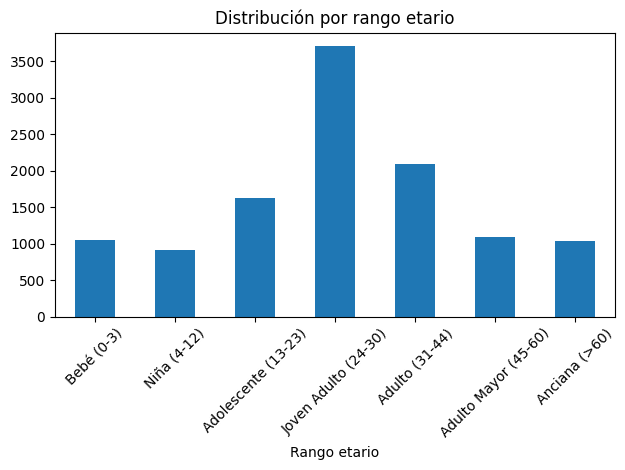

In [ ]:
label_names = [
    "Bebé (0-3)", "Niña (4-12)",
    "Adolescente (13-23)", "Joven Adulto (24-30)", "Adulto (31-44)",
    "Adulto Mayor (45-60)", "Anciana (>60)"
]

labels = [label for _, label in female_images]
class_counts = Counter(labels)

df = pd.DataFrame({
    'Rango etario': label_names,
    'Cantidad': [class_counts.get(i, 0) for i in range(7)]
})

print("📊 Cantidad de imágenes por rango etario:")
print(df.to_string(index=False))

df.plot(kind='bar', x='Rango etario', y='Cantidad', legend=False, title="Distribución por rango etario")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 5. Calcular pesos por clase

In [ ]:
total = sum(class_counts.values())
class_weights = [total / (class_counts.get(i, 0) + 1e-6) for i in range(7)]
class_weights = [w / sum(class_weights) for w in class_weights]
print("Pesos por clase:", class_weights)


Pesos por clase: [0.17957030243782318, 0.20639814475751123, 0.1164720608200393, 0.05104290693041883, 0.09064516228850134, 0.17300466067278908, 0.18286676209291708]


## 6. Preparar dataset y transformaciones

In [ ]:
train_imgs, val_imgs = train_test_split(female_images, test_size=0.2, random_state=42)

class UTKFaceDataset(Dataset):
    def __init__(self, image_label_list, transform=None):
        self.data = image_label_list
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name, label = self.data[idx]
        img_path = os.path.join(dataset_path, img_name)
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# Transformaciones para entrenamiento (con aumentos)
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Transformaciones para validación (solo resize y normalización)
transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

train_dataset = UTKFaceDataset(train_imgs, transform=transform_train)
val_dataset = UTKFaceDataset(val_imgs, transform=transform_val)


## 7. Definir modelo con ResNet50 preentrenada congelada

In [ ]:
import torchvision.models as models
import torch.nn as nn

class AgeClassifierResNet(nn.Module):
    def __init__(self, num_classes=7):
        super().__init__()
        self.model = models.resnet50(pretrained=True)

        # Congelar todos los parámetros excepto layer4 y fc
        for name, param in self.model.named_parameters():
            if "layer4" in name or "fc" in name:
                param.requires_grad = True
            else:
                param.requires_grad = False

        # Reemplazar la última capa FC para 7 clases en vez de las 1000 por defecto
        num_features = self.model.fc.in_features
        self.model.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        return self.model(x)

## 8. Entrenar 4 modelos con early stopping

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_configs = [
    {"name": "Modelo A", "lr": 0.00015, "batch_size": 32, "epochs": 30},
    {"name": "Modelo B", "lr": 0.00025, "batch_size": 48, "epochs": 30},
    {"name": "Modelo C", "lr": 0.0001, "batch_size": 64, "epochs": 30},
    {"name": "Modelo D", "lr": 0.00035, "batch_size": 40, "epochs": 30},
]

for config in model_configs:
    print(f"\n🎯 Entrenando {config['name']}")
    train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=False)

    model = AgeClassifierResNet().to(device)

    # Optimizar solo parámetros entrenables (layer4 y fc)
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=config["lr"])

    # Scheduler para ajustar learning rate según val_loss
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

    weights_tensor = torch.FloatTensor(class_weights).to(device)
    criterion = nn.CrossEntropyLoss(weight=weights_tensor)

    best_loss = float('inf')
    no_improve = 0

    for epoch in range(config["epochs"]):
        print(f"📈 {config['name']} - Época {epoch + 1}/{config['epochs']}")

        model.train()
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        train_loss = total_loss / len(train_loader)  # <--- CORRECCIÓN: Promediar train_loss

        # Validación
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        val_loss /= len(val_loader)
        print(f"🔍 train_loss={train_loss:.4f}, val_loss={val_loss:.4f}")

        # Ajustar learning rate según val_loss
        scheduler.step(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            no_improve = 0
            model_filename = f"{config['name'].replace(' ', '_')}_age_model_female_resnet.pt"
            torch.save(model, model_filename)
            print(f"✅ Modelo guardado: {model_filename}")
        else:
            no_improve += 1
            if no_improve >= 3:
                print("⛔ Early stopping.")
                break


🎯 Entrenando Modelo A


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 98.2MB/s]


📈 Modelo A - Época 1/30
🔍 train_loss=1.2547, val_loss=1.2589
✅ Modelo guardado: Modelo_A_age_model_female_resnet.pt
📈 Modelo A - Época 2/30
🔍 train_loss=1.0637, val_loss=1.0161
✅ Modelo guardado: Modelo_A_age_model_female_resnet.pt
📈 Modelo A - Época 3/30
🔍 train_loss=1.0106, val_loss=0.9494
✅ Modelo guardado: Modelo_A_age_model_female_resnet.pt
📈 Modelo A - Época 4/30
🔍 train_loss=0.9516, val_loss=1.0167
📈 Modelo A - Época 5/30
🔍 train_loss=0.9101, val_loss=1.0220
📈 Modelo A - Época 6/30
🔍 train_loss=0.8734, val_loss=0.9540
⛔ Early stopping.

🎯 Entrenando Modelo B
📈 Modelo B - Época 1/30
🔍 train_loss=1.2518, val_loss=1.2294
✅ Modelo guardado: Modelo_B_age_model_female_resnet.pt
📈 Modelo B - Época 2/30
🔍 train_loss=1.0726, val_loss=1.1117
✅ Modelo guardado: Modelo_B_age_model_female_resnet.pt
📈 Modelo B - Época 3/30
🔍 train_loss=0.9912, val_loss=1.0501
✅ Modelo guardado: Modelo_B_age_model_female_resnet.pt
📈 Modelo B - Época 4/30
🔍 train_loss=0.9346, val_loss=1.0049
✅ Modelo guardado: 

# 8.1 FineTunning

In [ ]:
from torchvision.models.resnet import ResNet
torch.serialization.add_safe_globals([ResNet])

# Configuración
model_path = "Modelo_B_age_model_female_resnet.pt"
finetuned_path = "Modelo_B_finetuned.pt"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Función auxiliar
def rango_to_edad_promedio(cat):
    return [1.5, 6.5, 11.5, 16.5, 25, 37.5, 52.5, 70][cat]

# Cargar el modelo original
model = torch.load(model_path, map_location=device, weights_only=False)
model.to(device)
model.train()

# 🔓 Descongelar solo layer3, layer4 y fc
for name, param in model.model.named_parameters():
    if any(layer in name for layer in ["layer3", "layer4", "fc"]):
        param.requires_grad = True
    else:
        param.requires_grad = False

# Optimizador con weight decay
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5, weight_decay=1e-4)

# Scheduler y criterio
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)
weights_tensor = torch.FloatTensor(class_weights).to(device)
criterion = nn.CrossEntropyLoss(weight=weights_tensor)

# Fine-tune
print("🎯 Fine-tune Modelo D")

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

best_loss = float('inf')
no_improve = 0
max_epochs = 8

for epoch in range(max_epochs):
    print(f"📈 Modelo D Fine-tune - Época {epoch + 1}/{max_epochs}")
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    train_loss = total_loss / len(train_loader)

    # Validación
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    val_loss /= len(val_loader)

    print(f"🔍 train_loss={train_loss:.4f}, val_loss={val_loss:.4f}")
    scheduler.step(val_loss)

    if val_loss < best_loss:
        best_loss = val_loss
        no_improve = 0
        torch.save(model, finetuned_path)
        print(f"✅ Fine-tune completo. Modelo guardado como {finetuned_path}")
    else:
        no_improve += 1
        if no_improve >= 2:
            print("⛔ Early stopping.")
            break

🎯 Fine-tune Modelo D
📈 Modelo D Fine-tune - Época 1/8
🔍 train_loss=0.5529, val_loss=0.8492
✅ Fine-tune completo. Modelo guardado como Modelo_B_finetuned.pt
📈 Modelo D Fine-tune - Época 2/8
🔍 train_loss=0.4997, val_loss=0.8687
📈 Modelo D Fine-tune - Época 3/8
🔍 train_loss=0.4598, val_loss=0.8844
⛔ Early stopping.


# Fine Tuning 8.2

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Cargar modelo completo previamente entrenado
model_path = "Modelo_B_age_model_female_resnet.pt"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = torch.load(model_path, map_location=device, weights_only=False)  # Cargar modelo completo
model.to(device)

# Descongelar layer2, layer3, layer4 y fc para fine tuning más profundo
for name, param in model.named_parameters():
    if any(layer in name for layer in ["layer2", "layer3", "layer4", "fc"]):
        param.requires_grad = True
    else:
        param.requires_grad = False

# Optimizador, loss, scheduler
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-6, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor(class_weights).to(device))
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

# Loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Fine-tuning loop
best_loss = float('inf')
no_improve = 0
max_epochs = 20
finetuned_path = "Modelo_B_finetuned_deep.pt"
best_epoch = 0

print("🎯 Fine-tuning del Modelo (layer2, layer3, layer4, fc)")

for epoch in range(max_epochs):
    print(f"📈 Época {epoch + 1}/{max_epochs}")

    # Entrenamiento
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    train_loss = total_loss / len(train_loader)

    # Validación
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    val_loss /= len(val_loader)

    print(f"🔍 train_loss={train_loss:.4f}, val_loss={val_loss:.4f}")
    scheduler.step(val_loss)

    if val_loss < best_loss:
        best_loss = val_loss
        no_improve = 0
        best_epoch = epoch + 1
        torch.save(model, finetuned_path)  # Guarda el modelo completo
        print(f"✅ Modelo mejorado guardado como: {finetuned_path} (época {best_epoch})")
    else:
        no_improve += 1
        if no_improve >= 3:
            print("⛔ Early stopping por no mejora.")
            break

print(f"🏁 Mejor modelo guardado en época {best_epoch} con val_loss={best_loss:.4f}")

🎯 Fine-tuning del Modelo (layer2, layer3, layer4, fc)
📈 Época 1/20
🔍 train_loss=0.6484, val_loss=0.6298
✅ Modelo mejorado guardado como: Modelo_B_finetuned_deep.pt (época 1)
📈 Época 2/20
🔍 train_loss=0.6275, val_loss=0.6169
✅ Modelo mejorado guardado como: Modelo_B_finetuned_deep.pt (época 2)
📈 Época 3/20
🔍 train_loss=0.6209, val_loss=0.6070
✅ Modelo mejorado guardado como: Modelo_B_finetuned_deep.pt (época 3)
📈 Época 4/20
🔍 train_loss=0.6037, val_loss=0.6035
✅ Modelo mejorado guardado como: Modelo_B_finetuned_deep.pt (época 4)
📈 Época 5/20
🔍 train_loss=0.6053, val_loss=0.5997
✅ Modelo mejorado guardado como: Modelo_B_finetuned_deep.pt (época 5)
📈 Época 6/20
🔍 train_loss=0.5923, val_loss=0.5993
✅ Modelo mejorado guardado como: Modelo_B_finetuned_deep.pt (época 6)
📈 Época 7/20
🔍 train_loss=0.5874, val_loss=0.5930
✅ Modelo mejorado guardado como: Modelo_B_finetuned_deep.pt (época 7)
📈 Época 8/20
🔍 train_loss=0.5767, val_loss=0.5895
✅ Modelo mejorado guardado como: Modelo_B_finetuned_deep

# 9. Evaluación de los modelos entrenados


📊 Evaluando Modelo_B_finetuned_deeper
✅ Accuracy: 69.37%
📉 MAE: 2.68 años
📊 Desvío estándar del error: 4.61
🎯 Precision (weighted): 0.6968
🎯 Recall (weighted): 0.6937
🎯 F1-Score (weighted): 0.6933


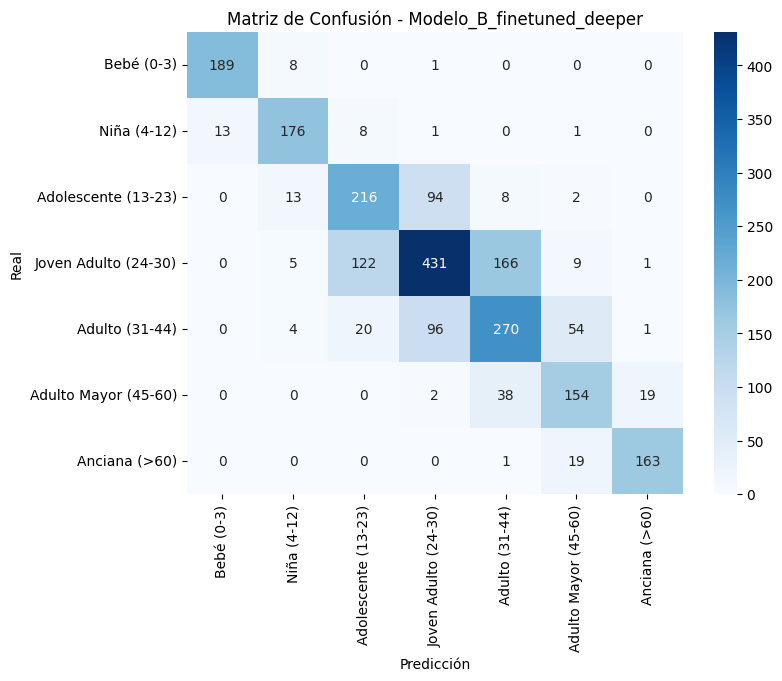

📋 Reporte de clasificación:
                      precision    recall  f1-score   support

          Bebé (0-3)       0.94      0.95      0.94       198
         Niña (4-12)       0.85      0.88      0.87       199
 Adolescente (13-23)       0.59      0.65      0.62       333
Joven Adulto (24-30)       0.69      0.59      0.63       734
      Adulto (31-44)       0.56      0.61      0.58       445
Adulto Mayor (45-60)       0.64      0.72      0.68       213
       Anciana (>60)       0.89      0.89      0.89       183

            accuracy                           0.69      2305
           macro avg       0.74      0.76      0.75      2305
        weighted avg       0.70      0.69      0.69      2305



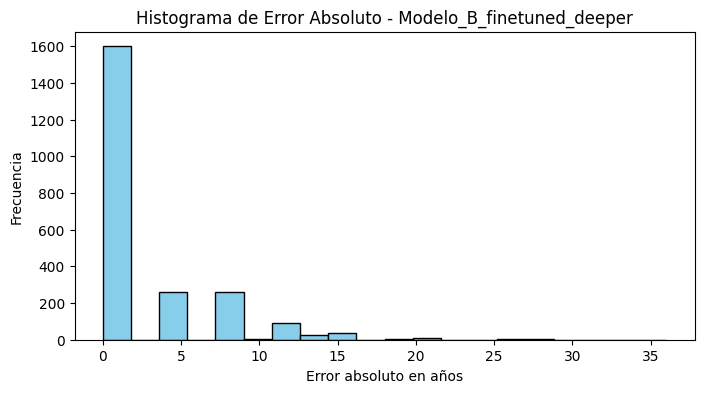

/tmp/ipython-input-13-3737797839.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=names, y=values, palette="viridis")


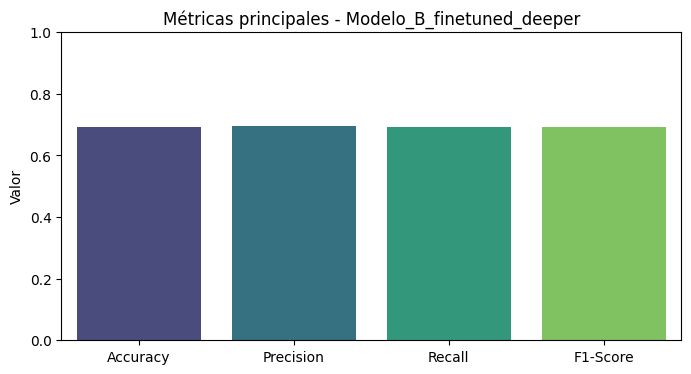

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(cm, classes, title='Matriz de Confusión'):
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.title(title)
    plt.show()

def plot_metric_bar(metrics, title):
    plt.figure(figsize=(8,4))
    names = list(metrics.keys())
    values = list(metrics.values())
    sns.barplot(x=names, y=values, palette="viridis")
    plt.ylim(0,1)
    plt.title(title)
    plt.ylabel('Valor')
    plt.show()

model_names = ["Modelo_B_finetuned_deeper"]

def rango_to_edad_promedio(cat):
    return [1.5, 6.5, 11.5, 16.5, 25, 37.5, 52.5, 70][cat]


for name in model_names:
    model_path = f"{name}.pt"
    if os.path.exists(model_path):
        print(f"\n📊 Evaluando {name}")

        model = torch.load(model_path, map_location=device, weights_only=False)
        model.eval()

        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

        errores = []
        correct = 0
        total = 0
        all_labels = []
        all_preds = []

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)

                edad_real = [rango_to_edad_promedio(l.item()) for l in labels]
                edad_pred = [rango_to_edad_promedio(p.item()) for p in predicted]
                errores += list(np.abs(np.array(edad_real) - np.array(edad_pred)))

                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(predicted.cpu().numpy())

                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        errores = np.array(errores)
        accuracy = 100 * correct / total
        mae = errores.mean()
        std = errores.std()

        # Métricas clásicas para clasificación
        precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
        recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
        f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

        print(f"✅ Accuracy: {accuracy:.2f}%")
        print(f"📉 MAE: {mae:.2f} años")
        print(f"📊 Desvío estándar del error: {std:.2f}")
        print(f"🎯 Precision (weighted): {precision:.4f}")
        print(f"🎯 Recall (weighted): {recall:.4f}")
        print(f"🎯 F1-Score (weighted): {f1:.4f}")

        # Mostrar matriz de confusión
        cm = confusion_matrix(all_labels, all_preds)
        plot_confusion_matrix(cm, label_names, title=f'Matriz de Confusión - {name}')

        # Reporte detallado de clasificación
        print("📋 Reporte de clasificación:")
        print(classification_report(all_labels, all_preds, target_names=label_names, zero_division=0))

        # Histograma de errores absolutos
        plt.figure(figsize=(8,4))
        plt.hist(errores, bins=20, color='skyblue', edgecolor='black')
        plt.title(f'Histograma de Error Absoluto - {name}')
        plt.xlabel('Error absoluto en años')
        plt.ylabel('Frecuencia')
        plt.show()

        # Gráfico de métricas principales
        metrics = {
            'Accuracy': accuracy/100,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1
        }
        plot_metric_bar(metrics, title=f'Métricas principales - {name}')

    else:
        print(f"⚠️ Modelo {name} no encontrado.")

# 10. Probar Modelo


In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import random
import torch
import os

# 🧠 Seleccionar dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 🧠 Modelo cargado
model_path = "Modelo_B_finetuned.pt"
model = torch.load(model_path, map_location=device, weights_only=False)
model.to(device)
model.eval()

# Rango etario por clase
age_ranges = [
    "0-3 (Bebé)",
    "4-9 (Niño)",
    "10-13 (Preadolescente)",
    "14-19 (Adolescente)",
    "20-30 (Joven adulto)",
    "31-44 (Adulto)",
    "45-60 (Adulto mayor)",
    "61+ (Anciano)"
]

# 🔍 Elegimos 5 imágenes de prueba al azar
samples = random.sample(val_imgs, 5)

# 🔁 Mostrar resultados
for img_name, true_class in samples:
    img_path = os.path.join(dataset_path, img_name)
    image_pil = Image.open(img_path).convert("RGB")

    # ✅ Obtener edad real desde el nombre del archivo
    real_age = int(img_name.split("_")[0])

    # Preprocesar imagen
    image_tensor = transform_val(image_pil).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image_tensor)
        predicted_class = output.argmax(dim=1).item()

    # Mostrar
    predicted_range = age_ranges[predicted_class]

    plt.imshow(image_pil)
    plt.axis("off")
    plt.title(f"🧠 Predicho: {predicted_range}\n✅ Edad real: {real_age} años")
    plt.show()

AttributeError: Can't get attribute 'AgeClassifierResNet' on <module '__main__'>